In [1]:
from collections import defaultdict
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import pandas as pd
import seaborn as sns
import os

from howso.nominal_substitution.substitution_engine import NominalSubstitutionEngine
from howso.synthesizer import Synthesizer
from howso.utilities import infer_feature_attributes
from howso.validator import Validator
from howso.validator.results import ValidatorResult


os.environ["LANG"] = "en_US.UTF-8"
os.environ["LC_ALL"] = "en_US.UTF-8"

# Set this to True if the dataset is deemed to already have been anonymized.
ALREADY_ANONYMIZED: bool = True

In [2]:
col_type_mapping = {
    'nih_age': 'Int64', 'nih_alcohol_frequency': 'Int64', 'nih_sex': 'Int64',
    'nih_asthma': 'Int64', 'nih_alc_sub_abuse': 'Int64', 'nih_autoimm': 'Int64',
    'nih_cancer_past_yr': 'Int64', 'nih_chronic_kidney_disease': 'Int64',
    'nih_chronic_lung': 'Int64', 'nih_copd': 'Int64', 'nih_cardiovascular_disease': 'Int64',
    'nih_depression': 'Int64', 'nih_diabetes': 'Int64', 'nih_hypertension': 'Int64',
    'nih_immunocompromised': 'Int64', 'nih_iv_drug_use': 'Int64',
    'nih_other_chronic_cond': 'Int64', 'nih_mental_health_disorder': 'Int64',
    'nih_sickle_cell_disease': 'Int64', 'cov_pan_chal_hlth_2': 'Int64',
    'cov_pan_chal_med_2': 'Int64', 'cov_pan_chlng_trans_2': 'Int64',
    'cov_tst_mthd_2': 'Int64', 'nih_abdom_pain': 'Int64', 'nih_cough': 'Int64',
    'nih_diff_breath': 'Int64', 'nih_fatigue': 'Int64', 'nih_fever_chills': 'Int64',
    'nih_headache': 'Int64', 'nih_muscle_ache': 'Int64',
    'nih_nausea_vomiting_diarrhea': 'Int64', 'nih_olfactory': 'Int64',
    'nih_other_symp': 'Int64', 'covid_pandemic_challenges_abod_2': 'Int64',
    'covid_pandemic_challenges_food_2': 'Int64', 'covid_pandemic_challenges_wate_2': 'Int64',
    'nih_throat_congestion_nose': 'Int64', 'nih_skin_rash': 'Int64',
    'covid_test_approval': 'Int64', 'covid_test_collection_setting': 'Int64',
    'covid_test_performed_location': 'Int64', 'covid_test_result': 'Int64',
    'covid_test_specimen_collector': 'Int64', 'covid_test_specimen_type': 'Int64',
    'covid_test_study_setting': 'Int64', 'covid_test_tar_dis_stat_2___1': 'Int64',
    'covid_test_tar_dis_stat_2___2': 'Int64', 'covid_test_tar_dis_stat_2___3': 'Int64',
    'covid_test_tar_dis_stat_2___4': 'Int64', 'covid_test_tar_dis_stat_2___5': 'Int64',
    'covid_test_tar_dis_stat_2___6': 'Int64', 'covid_test_tar_dis_stat_2___9': 'Int64',
    'covid_test_type': 'Int64', 'covid_vaccine': 'Int64', 'nih_employment': 'Int64',
    'nih_education': 'Int64', 'employed_ew': 'Int64', 'employed_healthcare_2': 'Int64',
    'family_income': 'Int64', 'flu_vaccine_season_3': 'Int64',
    'flu_vaccinehistind_2': 'Int64', 'gender_identity_term_2': 'Int64',
    'nih_insurance': 'Int64', 'hi_loss_covid': 'Int64', 'household_congregate_3': 'Int64',
    'household_famgen_3': 'Int64', 'household_homeless': 'Int64',
    'isolate_maintain_job': 'Int64', 'jobloss_covid19_2': 'Int64', 'language_english': 'Int64',
    'language_home___1': 'Int64', 'language_home___2': 'Int64', 'language_home___3': 'Int64',
    'language_home___4': 'Int64', 'language_home___5': 'Int64', 'language_home___6': 'Int64',
    'language_home___7': 'Int64', 'language_home___8': 'Int64', 'language_home___9': 'Int64',
    'language_home___90': 'Int64', 'language_home___99': 'Int64',
    'nih_lifetime_use_alcohol': 'Int64', 'positivemonth_covidtest_2': 'Int64',
    'positiveyear_covidtest_3': 'Int64', 'nih_pregnancy': 'Int64',
    'quarantine_maintain_job': 'Int64', 'race_ethn_asian_detail_3___1': 'Int64',
    'race_ethn_asian_detail_3___2': 'Int64', 'race_ethn_asian_detail_3___3': 'Int64',
    'race_ethn_asian_detail_3___4': 'Int64', 'race_ethn_asian_detail_3___5': 'Int64',
    'race_ethn_asian_detail_3___99': 'Int64', 'nih_ethnicity': 'Int64',
    'race_ethn_hispanic_detail_2___1': 'Int64', 'race_ethn_hispanic_detail_2___2': 'Int64',
    'race_ethn_hispanic_detail_2___3': 'Int64', 'race_ethn_hispanic_detail_2___4': 'Int64',
    'race_ethn_hispanic_detail_2___5': 'Int64', 'race_ethn_hispanic_detail_2___6': 'Int64',
    'race_ethn_hispanic_detail_2___7': 'Int64', 'race_ethn_hispanic_detail_2___99': 'Int64',
    'race_ethn_islander_detail_2___1': 'Int64', 'race_ethn_islander_detail_2___10': 'Int64',
    'race_ethn_islander_detail_2___11': 'Int64', 'race_ethn_islander_detail_2___12': 'Int64',
    'race_ethn_islander_detail_2___13': 'Int64', 'race_ethn_islander_detail_2___14': 'Int64',
    'race_ethn_islander_detail_2___2': 'Int64', 'race_ethn_islander_detail_2___3': 'Int64',
    'race_ethn_islander_detail_2___4': 'Int64', 'race_ethn_islander_detail_2___5': 'Int64',
    'race_ethn_islander_detail_2___6': 'Int64', 'race_ethn_islander_detail_2___7': 'Int64',
    'race_ethn_islander_detail_2___8': 'Int64', 'race_ethn_islander_detail_2___9': 'Int64',
    'race_ethn_islander_detail_2___99': 'Int64', 'recentmonth_covidtest_2': 'Int64',
    'recentresult_covidtest': 'Int64', 'recentyear_covidtest_3': 'Int64',
    'nih_disability': 'Int64', 'nih_health_status': 'Int64',
    'self_reported_weight_units_2': 'Int64', 'sex_orient_id': 'Int64',
    'nih_history_smoking': 'Int64', 'smoker_number': 'float64', 'test_accesseasy_2': 'Int64',
    'test_accesswhere_2': 'Int64', 'tested_for_covid': 'Int64',
    'tested_positive_for_covid': 'Int64', 'vaccine_avail': 'Int64',
    'vaccine_concerns_3___1': 'Int64', 'vaccine_concerns_3___10': 'Int64',
    'vaccine_concerns_3___2': 'Int64', 'vaccine_concerns_3___3': 'Int64',
    'vaccine_concerns_3___4': 'Int64', 'vaccine_concerns_3___5': 'Int64',
    'vaccine_concerns_3___6': 'Int64', 'vaccine_concerns_3___7': 'Int64',
    'vaccine_concerns_3___8': 'Int64', 'vaccine_concerns_3___9': 'Int64',
    'vaccine_concerns_3___96': 'Int64', 'vaccine_reasons_3___1': 'Int64',
    'vaccine_reasons_3___10': 'Int64', 'vaccine_reasons_3___11': 'Int64',
    'vaccine_reasons_3___2': 'Int64', 'vaccine_reasons_3___3': 'Int64',
    'vaccine_reasons_3___4': 'Int64', 'vaccine_reasons_3___5': 'Int64',
    'vaccine_reasons_3___6': 'Int64', 'vaccine_reasons_3___7': 'Int64',
    'vaccine_reasons_3___8': 'Int64', 'vaccine_reasons_3___9': 'Int64',
    'vaccine_reasons_3___96': 'Int64', 'nih_vape_freq': 'Int64', 'work_closecont_2': 'Int64',
    'work_ppe_2': 'Int64', 'work_wash_2': 'Int64', 'nih_zip': 'string', 'nih_weight': 'Int64',
    'nih_height': 'Int64', 'nih_race': 'Int64', 'nih_alcohol_yn': 'Int64',
    'nih_cig_smoke_freq': 'Int64', 'nih_smoking_yn': 'Int64'}
print(f'total number of columns being mapped: {len(col_type_mapping)}')

data_path = Path("/home", "sagemaker-user", "phs002660", "project14_DATA_transformcopy_v3_processed.csv")
df = pd.read_csv(data_path, dtype=col_type_mapping)
df = df.reset_index(drop=True)
print(df.columns)
print(f'total number of rows: {len(df)}')

# for model comparison for covid_test_result prediction, nulls from target feature should be removed and all-null columns should be removed as well
target_feature = 'covid_test_result'
df = df.dropna(subset=[target_feature])
df = df[df[target_feature] != 3]
print(f'after removing null and extraneous rows, df.shape: {df.shape}')
null_only_cols = df.columns[df.isna().all()].tolist()
print(null_only_cols)
df = df.drop(columns=null_only_cols)
df = df.reset_index(drop=True)
print(f'input dataframe shape after processing: {df.shape}')
pd.set_option('display.max_columns', None)
df.describe()

total number of columns being mapped: 164
Index(['nih_age', 'nih_alcohol_frequency', 'nih_sex', 'nih_asthma',
       'nih_alc_sub_abuse', 'nih_autoimm', 'nih_cancer_past_yr',
       'nih_chronic_kidney_disease', 'nih_chronic_lung', 'nih_copd',
       ...
       'work_closecont_2', 'work_ppe_2', 'work_wash_2', 'nih_zip',
       'nih_weight', 'nih_height', 'nih_race', 'nih_alcohol_yn',
       'nih_cig_smoke_freq', 'nih_smoking_yn'],
      dtype='object', length=164)
total number of rows: 5102
after removing null and extraneous rows, df.shape: (4582, 164)
['nih_alcohol_frequency', 'cov_tst_mthd_2', 'covid_pandemic_challenges_wate_2', 'employed_ew', 'family_income', 'nih_insurance', 'hi_loss_covid', 'household_congregate_3', 'nih_lifetime_use_alcohol', 'positivemonth_covidtest_2', 'positiveyear_covidtest_3', 'recentmonth_covidtest_2', 'recentresult_covidtest', 'recentyear_covidtest_3', 'nih_disability', 'nih_health_status', 'nih_history_smoking', 'smoker_number', 'test_accesseasy_2', 'test

,nih_age,nih_sex,nih_asthma,nih_alc_sub_abuse,nih_autoimm,nih_cancer_past_yr,nih_chronic_kidney_disease,nih_chronic_lung,nih_copd,nih_cardiovascular_disease,nih_depression,nih_diabetes,nih_hypertension,nih_immunocompromised,nih_iv_drug_use,nih_other_chronic_cond,nih_mental_health_disorder,nih_sickle_cell_disease,cov_pan_chal_hlth_2,cov_pan_chal_med_2,cov_pan_chlng_trans_2,nih_abdom_pain,nih_cough,nih_diff_breath,nih_fatigue,nih_fever_chills,nih_headache,nih_muscle_ache,nih_nausea_vomiting_diarrhea,nih_olfactory,nih_other_symp,covid_pandemic_challenges_abod_2,covid_pandemic_challenges_food_2,nih_throat_congestion_nose,nih_skin_rash,covid_test_approval,covid_test_collection_setting,covid_test_performed_location,covid_test_result,covid_test_specimen_collector,covid_test_specimen_type,covid_test_study_setting,covid_test_tar_dis_stat_2___1,covid_test_tar_dis_stat_2___2,covid_test_tar_dis_stat_2___3,covid_test_tar_dis_stat_2___4,covid_test_tar_dis_stat_2___5,covid_test_tar_dis_stat_2___6,covid_test_tar_dis_stat_2___9,covid_test_type,covid_vaccine,nih_employment,nih_education,employed_healthcare_2,flu_vaccine_season_3,flu_vaccinehistind_2,gender_identity_term_2,household_famgen_3,household_homeless,isolate_maintain_job,jobloss_covid19_2,language_english,language_home___1,language_home___2,language_home___3,language_home___4,language_home___5,language_home___6,language_home___7,language_home___8,language_home___9,language_home___90,language_home___99,nih_pregnancy,quarantine_maintain_job,race_ethn_asian_detail_3___1,race_ethn_asian_detail_3___2,race_ethn_asian_detail_3___3,race_ethn_asian_detail_3___4,race_ethn_asian_detail_3___5,race_ethn_asian_detail_3___99,nih_ethnicity,race_ethn_hispanic_detail_2___1,race_ethn_hispanic_detail_2___2,race_ethn_hispanic_detail_2___3,race_ethn_hispanic_detail_2___4,race_ethn_hispanic_detail_2___5,race_ethn_hispanic_detail_2___6,race_ethn_hispanic_detail_2___7,race_ethn_hispanic_detail_2___99,race_ethn_islander_detail_2___1,race_ethn_islander_detail_2___10,race_ethn_islander_detail_2___11,race_ethn_islander_detail_2___12,race_ethn_islander_detail_2___13,race_ethn_islander_detail_2___14,race_ethn_islander_detail_2___2,race_ethn_islander_detail_2___3,race_ethn_islander_detail_2___4,race_ethn_islander_detail_2___5,race_ethn_islander_detail_2___6,race_ethn_islander_detail_2___7,race_ethn_islander_detail_2___8,race_ethn_islander_detail_2___9,race_ethn_islander_detail_2___99,self_reported_weight_units_2,sex_orient_id,vaccine_avail,vaccine_concerns_3___1,vaccine_concerns_3___10,vaccine_concerns_3___2,vaccine_concerns_3___3,vaccine_concerns_3___4,vaccine_concerns_3___5,vaccine_concerns_3___6,vaccine_concerns_3___7,vaccine_concerns_3___8,vaccine_concerns_3___9,vaccine_concerns_3___96,vaccine_reasons_3___1,vaccine_reasons_3___10,vaccine_reasons_3___11,vaccine_reasons_3___2,vaccine_reasons_3___3,vaccine_reasons_3___4,vaccine_reasons_3___5,vaccine_reasons_3___6,vaccine_reasons_3___7,vaccine_reasons_3___8,vaccine_reasons_3___9,vaccine_reasons_3___96,nih_weight,nih_height,nih_race
count,4581.0,4518.0,71.0,71.0,71.0,71.0,71.0,1294.0,71.0,1294.0,71.0,1294.0,324.0,71.0,71.0,1294.0,71.0,71.0,79.0,79.0,79.0,649.0,1874.0,1873.0,1873.0,1875.0,652.0,1873.0,649.0,1873.0,1872.0,79.0,79.0,1875.0,649.0,3969.0,4011.0,4011.0,4582.0,4013.0,4011.0,4008.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,3969.0,214.0,147.0,227.0,42.0,27.0,117.0,142.0,168.0,3.0,155.0,117.0,2740.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,1482.0,4582.0,1482.0,556.0,102.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4581.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,429.0,282.0,78.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,4582.0,146.0,66.0,4581.0
mean,33.244925,0.585657,0.028169,0.0,0.0,0.0,0.0,0.001546,0.0,0.00541,

In [3]:
continuous_feats: list[str] = [
    'nih_age', 'nih_height', 'nih_weight'
]

# These features have been decided to be personally-identifying and, if they
# have not already been anonymized, will be replaced with novel nominals.
sensitive_nominal_feats: dict[str, str] = {
    "nih_zip": "int-id"
}

# These are non-personally-identifying nominals. Their values may be present in
# the resulting synthetic data, but necessary to maintain the predictiveness of
# the resulting synthetic data.
nominal_feats: list[str] = [
    'nih_sex', 'nih_asthma', 'nih_alc_sub_abuse', 'nih_autoimm', 'nih_cancer_past_yr', 
    'nih_chronic_kidney_disease', 'nih_chronic_lung', 'nih_copd', 'nih_cardiovascular_disease', 
    'nih_depression', 'nih_diabetes', 'nih_hypertension', 'nih_immunocompromised', 
    'nih_iv_drug_use', 'nih_other_chronic_cond', 'nih_mental_health_disorder', 'nih_sickle_cell_disease',
    'cov_pan_chal_hlth_2', 'cov_pan_chal_med_2', 'cov_pan_chlng_trans_2', 'nih_abdom_pain', 
    'nih_cough', 'nih_diff_breath', 'nih_fatigue', 'nih_fever_chills', 'nih_headache', 'nih_muscle_ache',
    'nih_nausea_vomiting_diarrhea', 'nih_olfactory', 'nih_other_symp', 'covid_pandemic_challenges_abod_2',
    'covid_pandemic_challenges_food_2', 'nih_throat_congestion_nose', 'nih_skin_rash', 'covid_test_approval',
    'covid_test_collection_setting', 'covid_test_performed_location', 'covid_test_result', 
    'covid_test_specimen_collector', 'covid_test_specimen_type', 'covid_test_study_setting', 
    'covid_test_tar_dis_stat_2___1', 'covid_test_tar_dis_stat_2___2', 'covid_test_tar_dis_stat_2___3', 
    'covid_test_tar_dis_stat_2___4', 'covid_test_tar_dis_stat_2___5', 'covid_test_tar_dis_stat_2___6', 
    'covid_test_tar_dis_stat_2___9', 'covid_test_type', 'covid_vaccine', 'nih_employment', 'nih_education', 
    'employed_healthcare_2', 'flu_vaccine_season_3', 'flu_vaccinehistind_2', 'gender_identity_term_2', 
    'household_famgen_3', 'household_homeless', 'isolate_maintain_job', 'jobloss_covid19_2', 
    'language_english', 'language_home___1', 'language_home___2', 'language_home___3', 'language_home___4', 
    'language_home___5', 'language_home___6', 'language_home___7', 'language_home___8', 'language_home___9', 
    'language_home___90', 'language_home___99', 'nih_pregnancy', 'quarantine_maintain_job', 
    'race_ethn_asian_detail_3___1', 'race_ethn_asian_detail_3___2', 'race_ethn_asian_detail_3___3', 
    'race_ethn_asian_detail_3___4', 'race_ethn_asian_detail_3___5', 'race_ethn_asian_detail_3___99', 
    'nih_ethnicity', 'race_ethn_hispanic_detail_2___1', 'race_ethn_hispanic_detail_2___2', 
    'race_ethn_hispanic_detail_2___3', 'race_ethn_hispanic_detail_2___4', 'race_ethn_hispanic_detail_2___5', 
    'race_ethn_hispanic_detail_2___6', 'race_ethn_hispanic_detail_2___7', 'race_ethn_hispanic_detail_2___99', 
    'race_ethn_islander_detail_2___1', 'race_ethn_islander_detail_2___10', 'race_ethn_islander_detail_2___11', 
    'race_ethn_islander_detail_2___12', 'race_ethn_islander_detail_2___13', 'race_ethn_islander_detail_2___14', 
    'race_ethn_islander_detail_2___2', 'race_ethn_islander_detail_2___3', 'race_ethn_islander_detail_2___4', 
    'race_ethn_islander_detail_2___5', 'race_ethn_islander_detail_2___6', 'race_ethn_islander_detail_2___7', 
    'race_ethn_islander_detail_2___8', 'race_ethn_islander_detail_2___9', 'race_ethn_islander_detail_2___99', 
    'self_reported_weight_units_2', 'sex_orient_id', 'vaccine_avail', 'vaccine_concerns_3___1', 
    'vaccine_concerns_3___10', 'vaccine_concerns_3___2', 'vaccine_concerns_3___3', 'vaccine_concerns_3___4', 
    'vaccine_concerns_3___5', 'vaccine_concerns_3___6', 'vaccine_concerns_3___7', 'vaccine_concerns_3___8', 
    'vaccine_concerns_3___9', 'vaccine_concerns_3___96', 'vaccine_reasons_3___1', 'vaccine_reasons_3___10', 
    'vaccine_reasons_3___11', 'vaccine_reasons_3___2', 'vaccine_reasons_3___3', 'vaccine_reasons_3___4', 
    'vaccine_reasons_3___5', 'vaccine_reasons_3___6', 'vaccine_reasons_3___7', 'vaccine_reasons_3___8', 
    'vaccine_reasons_3___9', 'vaccine_reasons_3___96', 'nih_race'
]

In [4]:
# Compute feature attributes
features = infer_feature_attributes(
    df,
    types={
        "continuous": continuous_feats,
        "nominal": list(sensitive_nominal_feats.keys()) + nominal_feats
    },
    # Let's use tight-bounds for the continuous
    tight_bounds=continuous_feats,
)

# Non-sensitive nominals should be marked as such
for nominal in nominal_feats:
    features[nominal]["non_sensitive"] = True

if ALREADY_ANONYMIZED:
    # If data is already anonymized, mark the "sensitive" features non-sensitive too.
    for nominal in sensitive_nominal_feats.keys():
        features[nominal]["non_sensitive"] = True
else:
    # Let's mark the sensitive nominals with the desired subtypes
    for nominal, subtype in sensitive_nominal_feats.items():
        features[nominal]["subtype"] = subtype

features.to_dataframe()


type decimal_places bounds                    \
                                                     min    max allow_null   
nih_age                 continuous            0.0    0.0   90.0       True   
nih_sex                    nominal            0.0    NaN    NaN       True   
nih_asthma                 nominal            0.0    NaN    NaN       True   
nih_alc_sub_abuse          nominal            0.0    NaN    NaN       True   
nih_autoimm                nominal            0.0    NaN    NaN       True   
...                            ...            ...    ...    ...        ...   
vaccine_reasons_3___96     nominal            0.0    NaN    NaN       True   
nih_zip                    nominal            NaN    NaN    NaN       True   
nih_weight              continuous            0.0   29.0  280.0       True   
nih_height              continuous            0.0   50.0   71.0       True   
nih_race                   nominal            0.0    NaN    NaN       True   

                                                 data_type non_sensitive  \
                       observed_min observed_max                           
nih_age                         0.0         90.0    number           NaN   
nih_sex                         NaN          NaN    number          True   
nih_asthma                      NaN          NaN    number          True   
nih_alc_sub_abuse               NaN          NaN    number          True   
nih_autoimm                     NaN          NaN    number          True   
...                             ...          ...       ...           ...   
vaccine_reasons_3___96          NaN          NaN    number          True   
nih_zip                         NaN          NaN    string          True   
nih_weight                     29.0        280.0    number           NaN   
nih_height                     50.0         71.0    number           NaN   
nih_race                        NaN          NaN    number          True   

                       original_type       
                           data_type size  
nih_age                      integer  8.0  
nih_sex                      integer  8.0  
nih_asthma                   integer  8.0  
nih_alc_sub_abuse            integer  8.0  
nih_autoimm                  integer  8.0  
...                              ...  ...  
vaccine_reasons_3___96       integer  8.0  
nih_zip                       string  NaN  
nih_weight                   integer  8.0  
nih_height                   integer  8.0  
nih_race                     integer  8.0  

[135 rows x 11 columns]

In [5]:
if not ALREADY_ANONYMIZED:
    # Before continuing, let's substitute sensitive features with replacement nominals.

    # Instantiate the NominalSubstitutionEngine
    substitution_engine = NominalSubstitutionEngine.factory(nominal_substitution_config={
        "nominals": {"default": {"locales": ["en_US"], "substitution": "naive"}},
    })
    df = substitution_engine.apply_substitutions(features, df)

    # Now that these replacements have been made, we no longer need these marked as sensitive.
    for feature in sensitive_nominal_feats.keys():
        features[feature]["subtype"] = None
        features[feature]["non_sensitive"] = True

    # Display the new dataframe and feature attributes
    display(df)
    display(features.to_dataframe())


In [6]:
desired_conviction_list = [0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 25.0]
synthed_dfs: list[pd.DataFrame] = []
validator_results: list[ValidatorResult] = []
metrics = [
    # This provides a privacy metric
    "AnonymityPreservation",
    # These are the 3 most typical used for Accuracy metrics
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",   # This will give us more detailed, per-feature accuracy metrics.
]

# Move desired_conviction loop out to the top so that we don't re-train the
# same trainee over and over.
for desired_conviction in desired_conviction_list:
    display(Markdown(f"## Processing desired_conviction={desired_conviction}"))

    with Synthesizer(privacy_override=True, use_id_privacy=False) as s:
        s.train(df, features=features)

        synth_df = s.synthesize_cases(
            n_samples=df.shape[0],
            desired_conviction=desired_conviction,
            generate_new_cases="always"
            # generate_new_cases="no"
        )
        synthed_dfs.append(synth_df)
        synth_df.to_csv(f'data/phs002660/gen_new_case_always/synthesized_{desired_conviction}.csv', 
                        index=False)
        with Validator(s, synth_df) as v:
            results = v.run_metrics(metrics)
        validator_results.append(results)

## Processing desired_conviction=0.1

Version 50.3.1 of Howso Engine™ is available. You are using version 50.2.1.


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=2.148
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=2.824
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=0.398
Run finished with overall_desirability=1.864


## Processing desired_conviction=0.5

Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=1.947
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=2.939
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=1.99
Run finished with overall_desirability=2.747


## Processing desired_conviction=1.0

Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=2.041
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.615
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.468
Run finished with overall_desirability=3.583


## Processing desired_conviction=3.0

Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=2.09
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.965
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.209
Run finished with overall_desirability=3.634


## Processing desired_conviction=5.0

Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=2.155
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.838
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.241
Run finished with overall_desirability=3.639


## Processing desired_conviction=10.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/utilities/internals.py:440: RuntimeWarning: The number of cases generated is less than number of cases requested (3433 < 4582). This might happen when `generate_new_cases` parameter is set to 'always', and the data is heavily constrained.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=2.624
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.423
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.487
Run finished with overall_desirability=3.768


## Processing desired_conviction=25.0

/home/sagemaker-user/howso-standalone/venv/lib/python3.12/site-packages/howso/utilities/internals.py:440: RuntimeWarning: The number of cases generated is less than number of cases requested (3395 < 4582). This might happen when `generate_new_cases` parameter is set to 'always', and the data is heavily constrained.
  warnings.warn(


Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=2.647
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=3.44
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=4.43
Run finished with overall_desirability=3.769


In [7]:
# Display the full metric details for each desirability_conviction level
for desired_conviction, synth_df, results in zip(desired_conviction_list, synthed_dfs, validator_results, strict=True):
    display(Markdown(f"## {desired_conviction=}"))
    for metric_name, result in results.items():
        display(metric_name)
        display(result.get_dataframe())

## desired_conviction=0.1

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,115.657282,6.183678,1.037416,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_abdom_pain,uniques,2.0,5.000000
1,1,generated,nih_abdom_pain,uniques,2.0,5.000000
2,1,original,nih_abdom_pain,mode,0.0,NaN
3,1,generated,nih_abdom_pain,mode,1.0,NaN
4,1,original,nih_abdom_pain,entropy,0.059582,0.030152
...,...,...,...,...,...,...
847,1,generated,gender_identity_term_2,uniques,2.0,5.000000
848,1,original,gender_identity_term_2,mode,1.0,NaN
849,1,generated,gender_identity_term_2,mode,0.0,NaN
850,1,original,gender_identity_term_2,entropy,0.678796,4.962518


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.435283,2.824


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,vaccine_concerns_3___2,None,NaN,NaN
1,1,NaN,Howso,vaccine_reasons_3___96,None,NaN,NaN
2,1,NaN,Howso,language_home___4,None,NaN,NaN
3,1,NaN,Howso,covid_test_approval,None,NaN,NaN
4,1,NaN,Howso,nih_alc_sub_abuse,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,gender_identity_term_2,precision,0.000174,4.964
758,1,original,Howso,gender_identity_term_2,mcc,0.081685,1.787
759,1,generated,Howso,gender_identity_term_2,mcc,-0.000430,1.787
760,1,original,Howso,gender_identity_term_2,accuracy,0.026172,4.375


## desired_conviction=0.5

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,94.84519,5.004397,1.036324,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,vaccine_concerns_3___4,uniques,2.0,5.000000
1,1,generated,vaccine_concerns_3___4,uniques,2.0,5.000000
2,1,original,vaccine_concerns_3___4,mode,0.0,NaN
3,1,generated,vaccine_concerns_3___4,mode,1.0,NaN
4,1,original,vaccine_concerns_3___4,entropy,0.007022,0.030152
...,...,...,...,...,...,...
847,1,generated,quarantine_maintain_job,uniques,4.0,5.000000
848,1,original,quarantine_maintain_job,mode,2.0,NaN
849,1,generated,quarantine_maintain_job,mode,99.0,NaN
850,1,original,quarantine_maintain_job,entropy,1.141776,4.161773


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.4122,2.939


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,vaccine_reasons_3___11,None,NaN,NaN
1,1,NaN,Howso,language_home___2,None,NaN,NaN
2,1,NaN,Howso,nih_alc_sub_abuse,None,NaN,NaN
3,1,NaN,Howso,nih_iv_drug_use,None,NaN,NaN
4,1,NaN,Howso,vaccine_concerns_3___8,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,quarantine_maintain_job,precision,0.000002,4.952
758,1,original,Howso,quarantine_maintain_job,mcc,0.076433,1.002
759,1,generated,Howso,quarantine_maintain_job,mcc,-0.023105,1.002
760,1,original,Howso,quarantine_maintain_job,accuracy,0.023991,3.848


## desired_conviction=1.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,49.93939,1.641469,1.083893,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,vaccine_concerns_3___5,uniques,2.0,5.000000
1,1,generated,vaccine_concerns_3___5,uniques,2.0,5.000000
2,1,original,vaccine_concerns_3___5,mode,0.0,NaN
3,1,generated,vaccine_concerns_3___5,mode,0.0,NaN
4,1,original,vaccine_concerns_3___5,entropy,0.003813,0.030152
...,...,...,...,...,...,...
847,1,generated,language_home___4,uniques,1.0,5.000000
848,1,original,language_home___4,mode,0.0,NaN
849,1,generated,language_home___4,mode,0.0,NaN
850,1,original,language_home___4,entropy,0.0,5.000000


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.277044,3.615


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_cancer_past_yr,None,NaN,NaN
1,1,NaN,Howso,race_ethn_islander_detail_2___10,None,NaN,NaN
2,1,NaN,Howso,race_ethn_islander_detail_2___11,None,NaN,NaN
3,1,NaN,Howso,race_ethn_islander_detail_2___12,None,NaN,NaN
4,1,NaN,Howso,race_ethn_islander_detail_2___13,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,jobloss_covid19_2,precision,0.001186,4.884
758,1,original,Howso,jobloss_covid19_2,mcc,0.063941,4.570
759,1,generated,Howso,jobloss_covid19_2,mcc,0.076207,4.570
760,1,original,Howso,jobloss_covid19_2,accuracy,0.021810,5.000


## desired_conviction=3.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,41.367192,1.017015,1.173084,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,sex_orient_id,uniques,3.0,5.000000
1,1,generated,sex_orient_id,uniques,3.0,5.000000
2,1,original,sex_orient_id,mode,99.0,NaN
3,1,generated,sex_orient_id,mode,99.0,NaN
4,1,original,sex_orient_id,entropy,0.126437,0.030152
...,...,...,...,...,...,...
847,1,generated,nih_hypertension,uniques,2.0,5.000000
848,1,original,nih_hypertension,mode,0.0,NaN
849,1,generated,nih_hypertension,mode,0.0,NaN
850,1,original,nih_hypertension,entropy,0.158411,0.030152


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.206959,3.965


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,language_home___3,None,NaN,NaN
1,1,NaN,Howso,language_home___7,None,NaN,NaN
2,1,NaN,Howso,nih_depression,None,NaN,NaN
3,1,NaN,Howso,nih_mental_health_disorder,None,NaN,NaN
4,1,NaN,Howso,nih_autoimm,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,nih_hypertension,precision,0.004449,4.999
758,1,original,Howso,nih_hypertension,mcc,0.000000,4.497
759,1,generated,Howso,nih_hypertension,mcc,0.009406,4.497
760,1,original,Howso,nih_hypertension,accuracy,0.066521,5.000


## desired_conviction=5.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,37.913258,1.001931,1.220864,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_height,max,71.0,5.000000
1,1,generated,nih_height,max,71.0,5.000000
2,1,original,nih_height,min,50.0,5.000000
3,1,generated,nih_height,min,50.0,5.000000
4,1,original,nih_height,mean,63.212121,4.965857
...,...,...,...,...,...,...
847,1,generated,vaccine_reasons_3___9,uniques,2.0,5.000000
848,1,original,vaccine_reasons_3___9,mode,0.0,NaN
849,1,generated,vaccine_reasons_3___9,mode,0.0,NaN
850,1,original,vaccine_reasons_3___9,entropy,0.002058,0.030152


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.232365,3.838


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,vaccine_concerns_3___3,None,NaN,NaN
1,1,NaN,Howso,vaccine_reasons_3___10,None,NaN,NaN
2,1,NaN,Howso,nih_autoimm,None,NaN,NaN
3,1,NaN,Howso,language_home___3,None,NaN,NaN
4,1,NaN,Howso,nih_depression,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,vaccine_reasons_3___9,precision,1.0,5.0
758,1,original,Howso,vaccine_reasons_3___9,mcc,0.0,5.0
759,1,generated,Howso,vaccine_reasons_3___9,mcc,0.0,5.0
760,1,original,Howso,vaccine_reasons_3___9,accuracy,1.0,5.0


## desired_conviction=10.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,8.260148,1.005619,1.365427,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,nih_education,uniques,8.0,5.000000
1,1,generated,nih_education,uniques,8.0,5.000000
2,1,original,nih_education,mode,1.0,NaN
3,1,generated,nih_education,mode,1.0,NaN
4,1,original,nih_education,entropy,1.459859,4.858716
...,...,...,...,...,...,...
847,1,generated,vaccine_concerns_3___2,uniques,1.0,5.000000
848,1,original,vaccine_concerns_3___2,mode,0.0,NaN
849,1,generated,vaccine_concerns_3___2,mode,0.0,NaN
850,1,original,vaccine_concerns_3___2,entropy,0.0,5.000000


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.315372,3.423


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,nih_iv_drug_use,None,NaN,NaN
1,1,NaN,Howso,vaccine_reasons_3___96,None,NaN,NaN
2,1,NaN,Howso,language_home___99,None,NaN,NaN
3,1,NaN,Howso,language_home___2,None,NaN,NaN
4,1,NaN,Howso,nih_autoimm,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,nih_weight,rmse,20.160158,2.612000
758,1,original,Howso,nih_weight,spearman,0.479682,4.888000
759,1,generated,Howso,nih_weight,spearman,0.489814,4.888000
760,1,original,Howso,nih_weight,r2,-29.213123,3.456155


## desired_conviction=25.0

'AnonymityPreservation'

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1,"(0.049787068367863944, 5, 20)",1,min,7.947111,1.000147,1.378681,5.0


'DescriptiveStatistics'

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1,original,language_home___9,uniques,1.0,5.000000
1,1,generated,language_home___9,uniques,1.0,5.000000
2,1,original,language_home___9,mode,1.0,NaN
3,1,generated,language_home___9,mode,1.0,NaN
4,1,original,language_home___9,entropy,0.0,5.000000
...,...,...,...,...,...,...
847,1,generated,jobloss_covid19_2,uniques,2.0,5.000000
848,1,original,jobloss_covid19_2,mode,0.0,NaN
849,1,generated,jobloss_covid19_2,mode,0.0,NaN
850,1,original,jobloss_covid19_2,entropy,0.48336,2.931613


'JointProbability'

,run_number,k,p,js,desirability
0,1,"[0.049787068367863944, 5, 20]",1,0.312068,3.44


'ModelComparison'

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,language_home___9,None,NaN,NaN
1,1,NaN,Howso,language_home___3,None,NaN,NaN
2,1,NaN,Howso,nih_mental_health_disorder,None,NaN,NaN
3,1,NaN,Howso,vaccine_reasons_3___11,None,NaN,NaN
4,1,NaN,Howso,covid_test_tar_dis_stat_2___5,None,NaN,NaN
...,...,...,...,...,...,...,...
757,1,generated,Howso,jobloss_covid19_2,precision,0.004748,4.880
758,1,original,Howso,jobloss_covid19_2,mcc,0.003296,0.689
759,1,generated,Howso,jobloss_covid19_2,mcc,0.154813,0.689
760,1,original,Howso,jobloss_covid19_2,accuracy,0.019629,4.897


In [8]:
# Create a summary DataFrame
final_result = pd.DataFrame()
data: dict[str, list] = defaultdict(list)

for desired_conviction, validator_result in zip(desired_conviction_list, validator_results):
    data["desired_conviction"].append(desired_conviction)
    for metric in metrics:
        data[metric].append(validator_result[metric].desirability)

final_result = pd.DataFrame(data)

display(final_result)


,desired_conviction,AnonymityPreservation,DescriptiveStatistics,JointProbability,ModelComparison
0,0.1,5.0,2.148,2.824,0.398
1,0.5,5.0,1.947,2.939,1.990
2,1.0,5.0,2.041,3.615,4.468
3,3.0,5.0,2.090,3.965,4.209
4,5.0,5.0,2.155,3.838,4.241
5,10.0,5.0,2.624,3.423,4.487
6,25.0,5.0,2.647,3.440,4.430


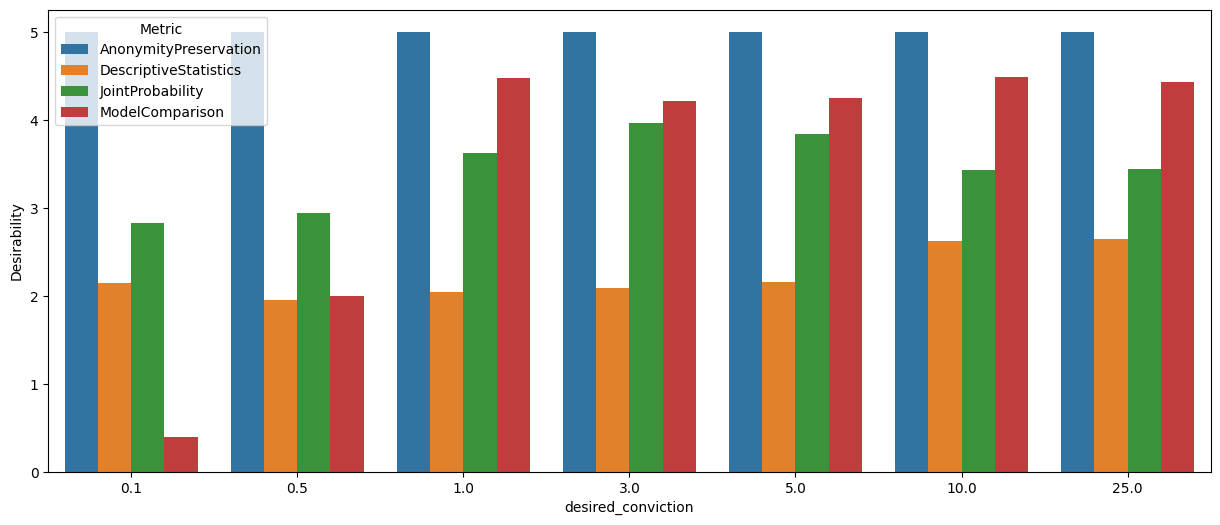

In [9]:
import matplotlib.pyplot as plt

# Melt the dataframe to long format
melted_df = final_result.melt(
    id_vars="desired_conviction",
    value_vars=metrics,
    var_name="Metric",
    value_name="Desirability"
)

# Create grouped bar chart
plt.figure(figsize=(15, 6))
sns.barplot(data=melted_df, x="desired_conviction", y="Desirability", hue="Metric")
plt.show()

nih_age Int64 0 90
nih_weight Int64 29 280
nih_height Int64 50 71


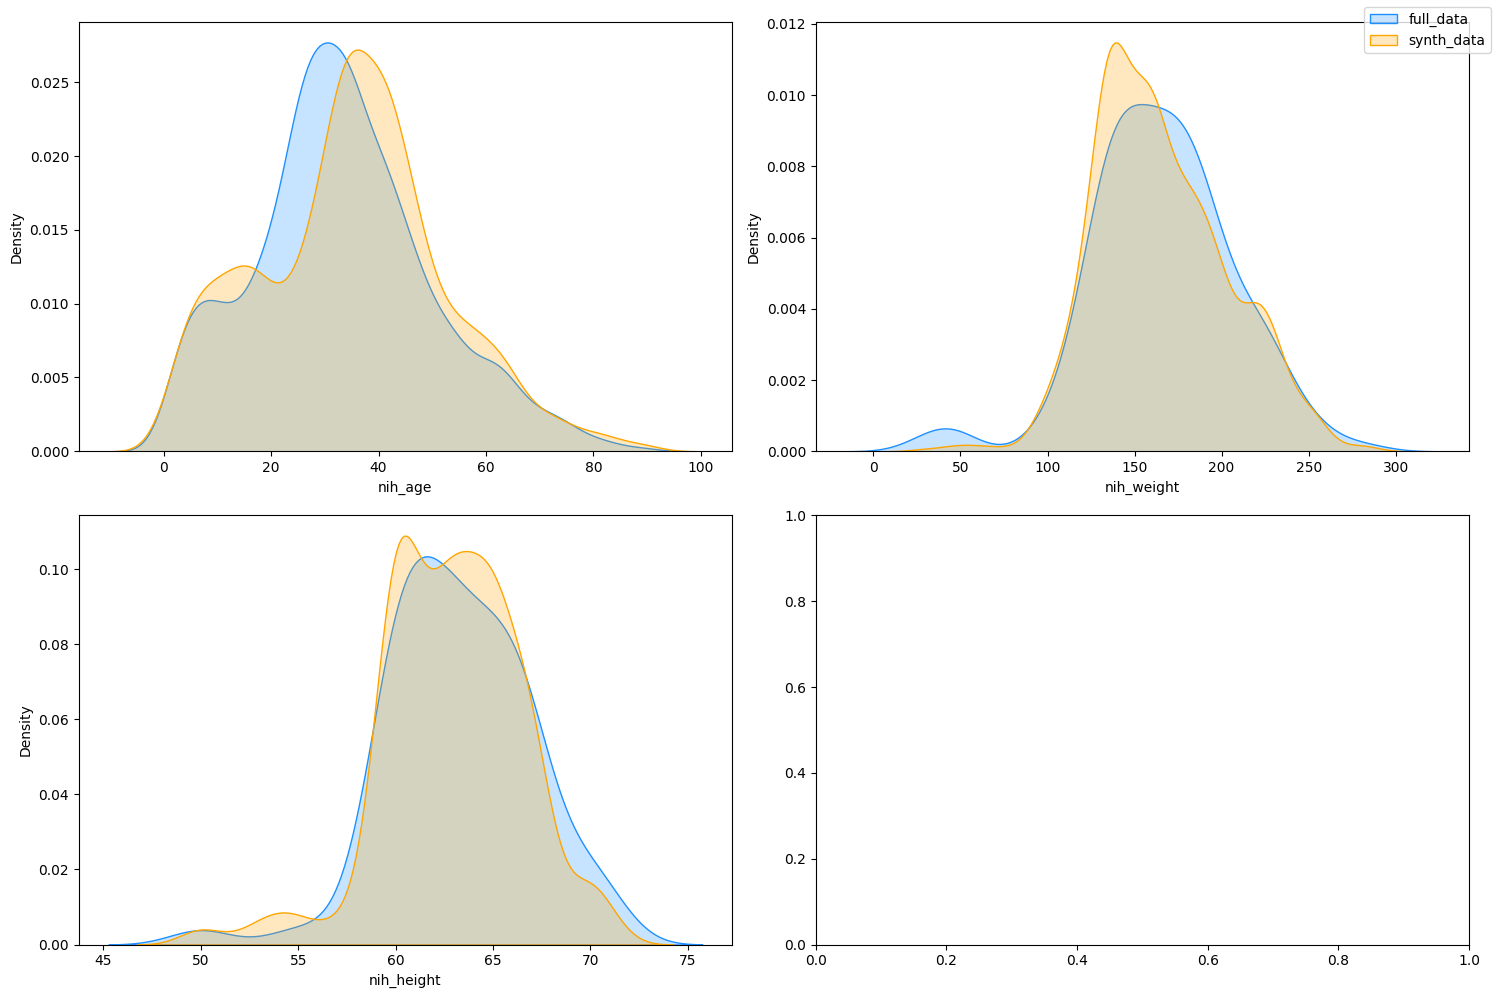

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]

gen_df = synthed_dfs[-1]  # Using the one with the highest accuracy (theoretically)

for c, ax in zip(df.columns.drop(categorical_features), axes.flat):
    print(c, df[c].dtypes, df[c].min(), df[c].max())
    if df[c].dtypes != 'string':
        sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
        sns.kdeplot(ax=ax, x=gen_df[c], color="orange", label="full_data", fill=True)
        ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [11]:
# Display the full ModelComparison results dataframe for the final run
with pd.option_context('display.max_rows', None):
    display(validator_results[-1]["ModelComparison"].get_dataframe())

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1,NaN,Howso,language_home___9,None,NaN,NaN
1,1,NaN,Howso,language_home___3,None,NaN,NaN
2,1,NaN,Howso,nih_mental_health_disorder,None,NaN,NaN
3,1,NaN,Howso,vaccine_reasons_3___11,None,NaN,NaN
4,1,NaN,Howso,covid_test_tar_dis_stat_2___5,None,NaN,NaN
5,1,NaN,Howso,covid_test_tar_dis_stat_2___6,None,NaN,NaN
6,1,NaN,Howso,covid_test_tar_dis_stat_2___9,None,NaN,NaN
7,1,NaN,Howso,vaccine_concerns_3___3,None,NaN,NaN
8,1,NaN,Howso,language_home___8,None,NaN,NaN
9,1,NaN,Howso,vaccine_reasons_3___96,None,NaN,NaN
